In [1]:
import os
import shutil

# Path to the output directory
output_dir = '/kaggle/working/'

# List all files in the output directory
files = os.listdir(output_dir)

# Iterate over each file and remove it
for file in files:
    file_path = os.path.join(output_dir, file)
    
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print(f'Failed to delete {file_path}. Reason: {e}')


In [2]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=4):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.epoch = 0

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.down5 = Down(1024, 2048)
        factor = 2 
        self.down6 = Down(2048, 4096 // factor)
        self.up1 = Up(4096, 2048 // factor)
        self.up2 = Up(2048, 1024 // factor)
        self.up3 = Up(1024, 512 // factor)
        self.up4 = Up(512, 256 // factor)
        self.up5 = Up(256, 128 // factor)
        self.up6 = Up(128, 64)
        self.output_layer = OutConv(64, n_classes)



    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)
        x7 = self.down6(x6)
        out = self.up1(x7, x6)
        out = self.up2(out, x5)
        out = self.up3(out, x4)
        out = self.up4(out, x3)
        out = self.up5(out, x2)
        out = self.up6(out, x1)
        out = self.output_layer(out)
        out = torch.sigmoid(out)
        return out

    
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
            
        )
        

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
            
        )
        

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Use the normal convolutions to reduce the number of channels
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
        


class OutConv(nn.Module):
    '''
    Simple convolution.
    '''
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        

    def forward(self, x):
        return self.conv(x)


In [3]:
def refine_seg(pred):
    '''
    Only retain the biggest connected component of a segmentation map.
    '''
    np_pred = pred.numpy()
        
    largest_ccs = []
    for i in range(np_pred.shape[0]):
        labeled, ncomponents = label(np_pred[i,:,:])
        bincounts = np.bincount(labeled.flat)[1:]
        if len(bincounts) == 0:
            largest_cc = labeled == 0
        else:
            largest_cc = labeled == np.argmax(bincounts)+1
        largest_cc = torch.tensor(largest_cc, dtype=torch.float32)
        largest_ccs.append(largest_cc)
    largest_ccs = torch.stack(largest_ccs)
    
    return largest_ccs

In [4]:
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
from scipy.ndimage import label
from skimage import measure
import matplotlib.patches as patches
import zipfile

# Load your pre-trained model (replace with your model loading code)
model = UNet(n_channels=3, n_classes=4)
model.load_state_dict(torch.load('/kaggle/input/testing-model-coarse/OD_OC_Coarse_Model_Larger.pth'))
model.eval()

# Set device to CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


# Function to load images from a folder
def load_images_from_folder(folder):
    images = []
    filenames = []
    for filename in sorted(os.listdir(folder)):  # Ensure filenames are sorted
        img = Image.open(os.path.join(folder, filename)).convert("RGB")
        if img is not None:
            images.append(img)
            filenames.append(filename)
    return images, filenames

# Function to resize the predicted mask to the original image size
def resize_mask(mask, original_size):
    mask = Image.fromarray(mask.squeeze().numpy().astype(np.uint8) * 255)
    mask = mask.resize(original_size, Image.NEAREST)
    return np.array(mask) // 255

# Function to visualize the bounding boxes and save the image
def visualize_predictions(image, pred_od, pred_oc, original_size, filename, save_dir):
    fig, ax = plt.subplots(1, figsize=(8, 8))

    # Original Image
    ax.imshow(image)
    ax.set_title(f"{filename} with Segmentation Borders")
    ax.axis("off")

    # Resize predicted masks to the original image size
    pred_od_resized = resize_mask(pred_od, original_size)
    pred_oc_resized = resize_mask(pred_oc, original_size)

    # Find contours for the predicted masks
    od_contours = measure.find_contours(pred_od_resized, 0.5)
    oc_contours = measure.find_contours(pred_oc_resized, 0.5)

    # Draw the contours on the original image
    for contour in od_contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')

    for contour in oc_contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='blue')

    # Save the figure with the same filename
    plt.savefig(os.path.join(save_dir, filename))
    plt.close(fig)

# Function to get model predictions
def get_predictions(image, model):
    img = transforms.functional.to_tensor(image)
    img = transforms.functional.resize(img, (256, 256), interpolation=transforms.InterpolationMode.BILINEAR)
    image = img.unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image)
    return outputs

# Path to your test images
test_folder = '/kaggle/input/cropped-test-images/Enhanced_Test_Images'
save_folder = '/kaggle/working/contoured_images'

# Create directory for saving contoured images
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# Load test images
test_images, filenames = load_images_from_folder(test_folder)

# Apply the model to each test image and visualize the results
for i, (image, filename) in enumerate(zip(test_images, filenames)):
    logits = get_predictions(image, model)
    pred_od = refine_seg((logits[:, 0, :, :] >= 0.5).type(torch.int8).cpu())
    pred_oc = refine_seg((logits[:, 1, :, :] >= 0.5).type(torch.int8).cpu())
    pred_od_bd = refine_seg((logits[:, 2, :, :] >= 0.5).type(torch.int8).cpu())
    pred_oc_bd = refine_seg((logits[:, 3, :, :] >= 0.5).type(torch.int8).cpu())
    
    # Convert image to numpy array for visualization
    image_np = np.array(image)
    original_size = image.size  # Get original image size
    
    # Visualize predictions and save images with the same filename
    visualize_predictions(image_np, pred_od, pred_oc, original_size, filename, save_folder)

# Zip the saved images
zip_filename = '/kaggle/working/contoured_images.zip'
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for root, _, files in os.walk(save_folder):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), save_folder))


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


# Fine Seg

In [5]:
import cv2

def convert_to_distance_map(pred):
    """
    Convert prediction to a distance map using distance transform.
    """
    # Ensure binary image for distance transform
    binary_pred = (pred > 0).astype(np.uint8)
    # Compute the distance transform
    dist_map = cv2.distanceTransform(binary_pred, cv2.DIST_L2, 3)
    return dist_map

def normalize_map(dist_map):
    """
    Normalize the distance map to the range 0-255.
    """
    normalized_map = cv2.normalize(dist_map, None, 0, 255, cv2.NORM_MINMAX)
    return normalized_map.astype(np.uint8)



In [8]:
def generate_dsi_images(model, output_dir):
    # Set model to evaluation mode
    model.eval()
    
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    with torch.no_grad():
        for i, (img, filename) in enumerate(zip(test_images, filenames)):
            # Get predictions from the model
            original_size = img.size
            logits = get_predictions(img, model)
            pred_od = (logits[:, 0, :, :] >= 0.5).cpu()
            pred_oc = (logits[:, 1, :, :] >= 0.5).cpu()
            boundary_pred_od = (logits[:, 2, :, :] >= 0.5).cpu()
            boundary_pred_oc = (logits[:, 3, :, :] >= 0.5).cpu()
            
            pred_od = resize_mask(pred_od, original_size)
            pred_oc = resize_mask(pred_oc, original_size)
            boundary_pred_od = resize_mask(boundary_pred_od, original_size)
            boundary_pred_oc = resize_mask(boundary_pred_oc, original_size)
            
            od_dist_map = convert_to_distance_map(pred_od)
            oc_dist_map = convert_to_distance_map(pred_oc)
            boundary_od_dist_map = convert_to_distance_map(boundary_pred_od)
            boundary_oc_dist_map = convert_to_distance_map(boundary_pred_oc)

            # Normalize the distance maps
            norm_od_dist_map = normalize_map(od_dist_map)
            norm_oc_dist_map = normalize_map(oc_dist_map)
            norm_boundary_od_dist_map = normalize_map(boundary_od_dist_map)
            norm_boundary_oc_dist_map = normalize_map(boundary_oc_dist_map)

            # Sum the normalized distance maps to create the DSI
            dsi = norm_od_dist_map + norm_oc_dist_map + norm_boundary_od_dist_map + norm_boundary_oc_dist_map

            # Optionally, you can further normalize the DSI
            final_dsi = normalize_map(dsi)

            # Save the DSI image with the same name as the original image
            
            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, final_dsi)

            print(f'Saved DSI image {i + 1} to {output_path}', end='\r')

In [9]:
print("Data and model loaded. Starting to generate DSI images fordata.")
# Generate and save DSI images for training data
output_dir = '/kaggle/working/test_dsi_images'
generate_dsi_images(model, output_dir)

print("Finished generating DSI images for data.")

Data and model loaded. Starting to generate DSI images fordata.
Finished generating DSI images for data.st_dsi_images/cropped_Picture9.pngg


# Fine Seg output

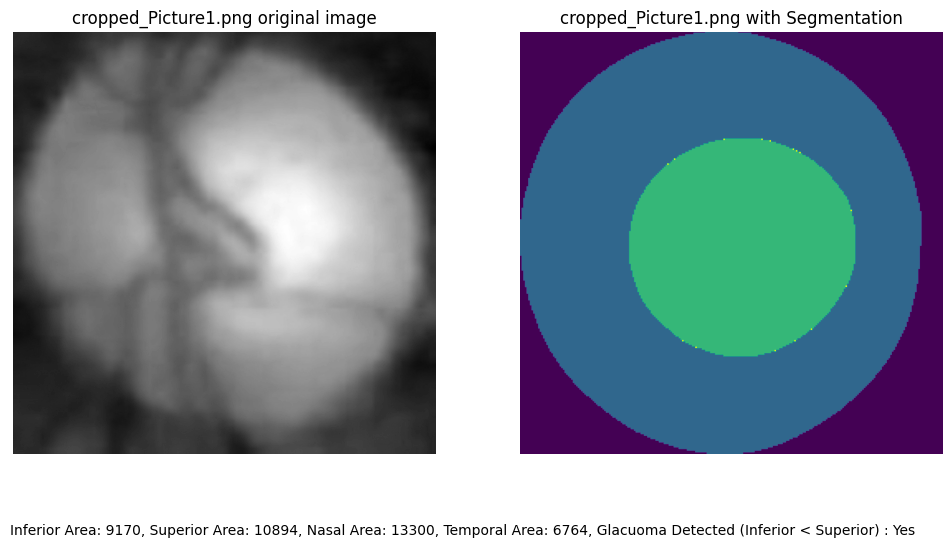

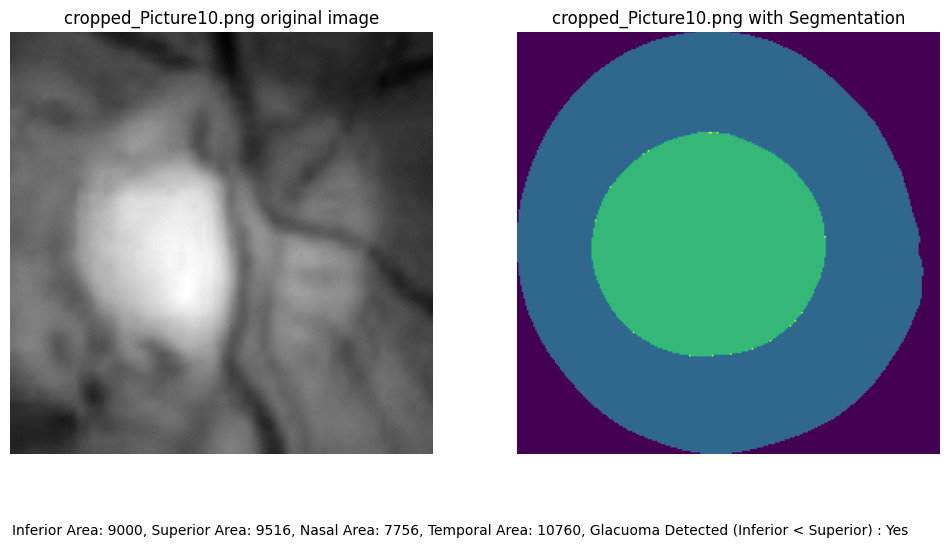

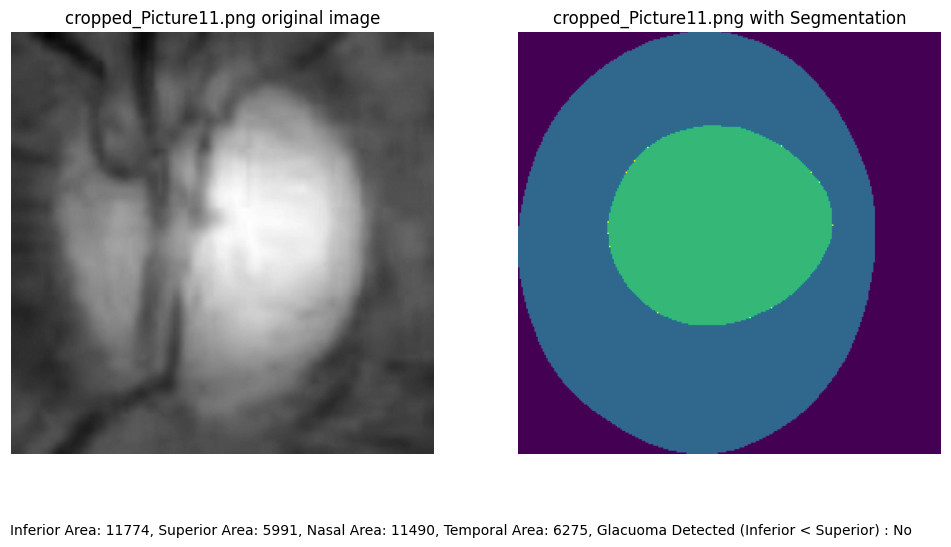

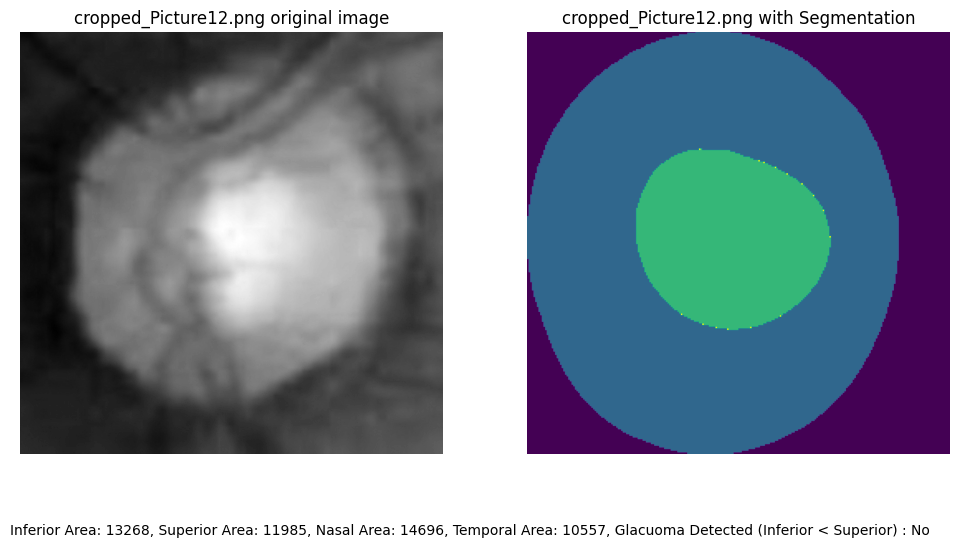

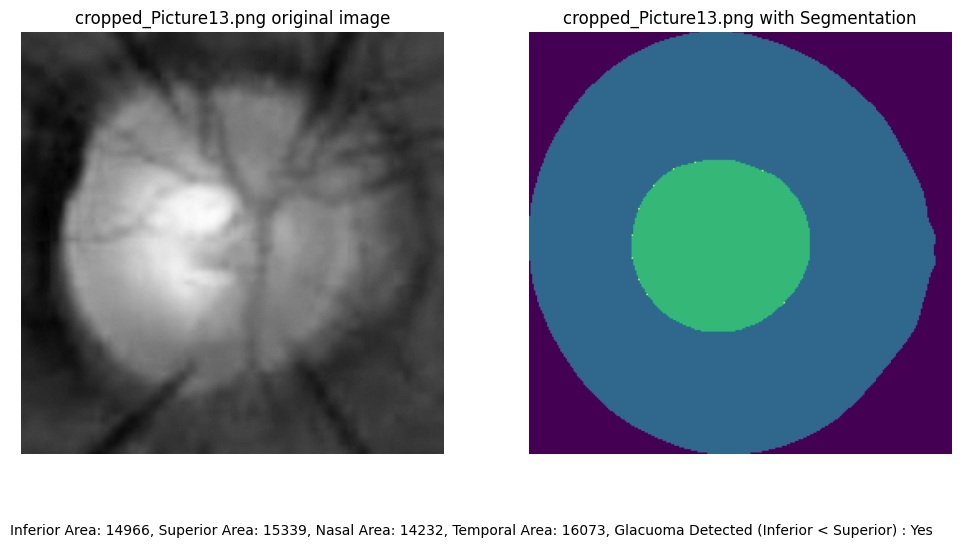

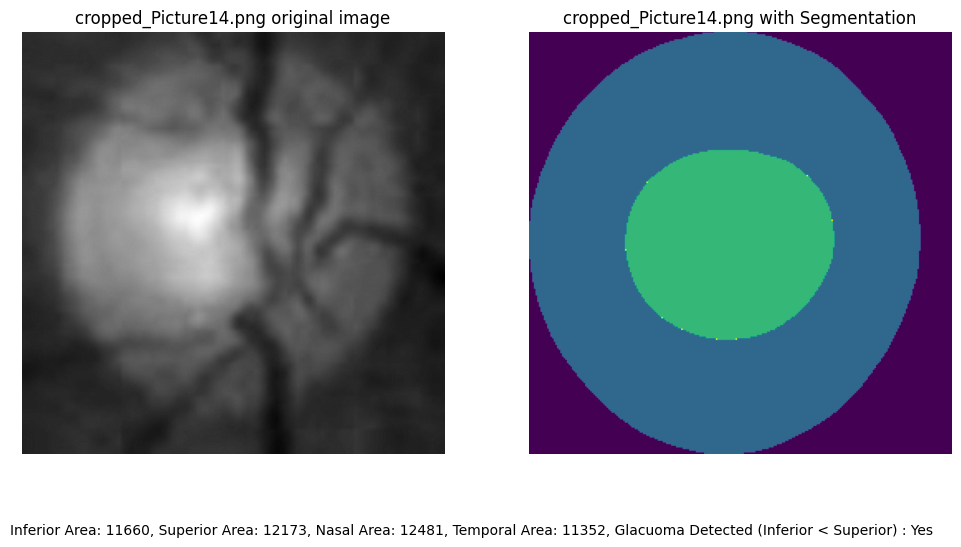

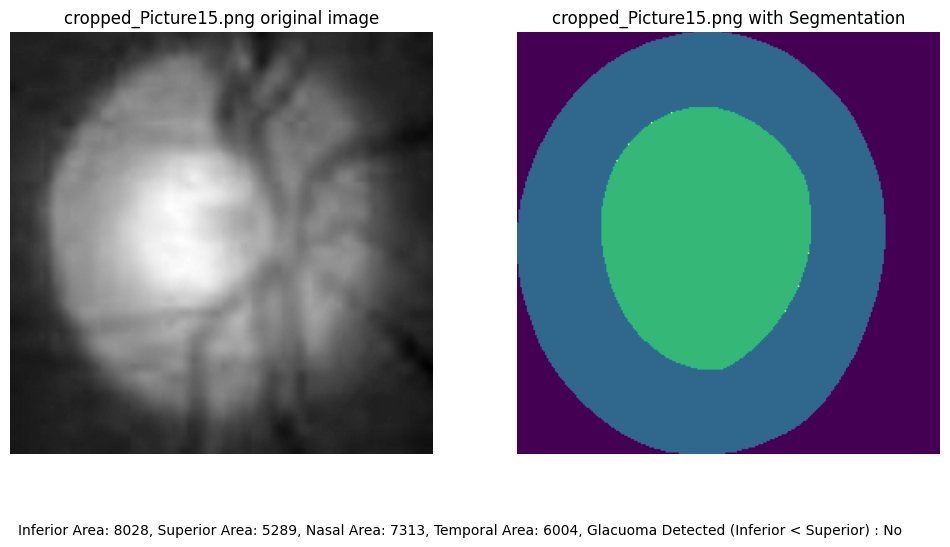

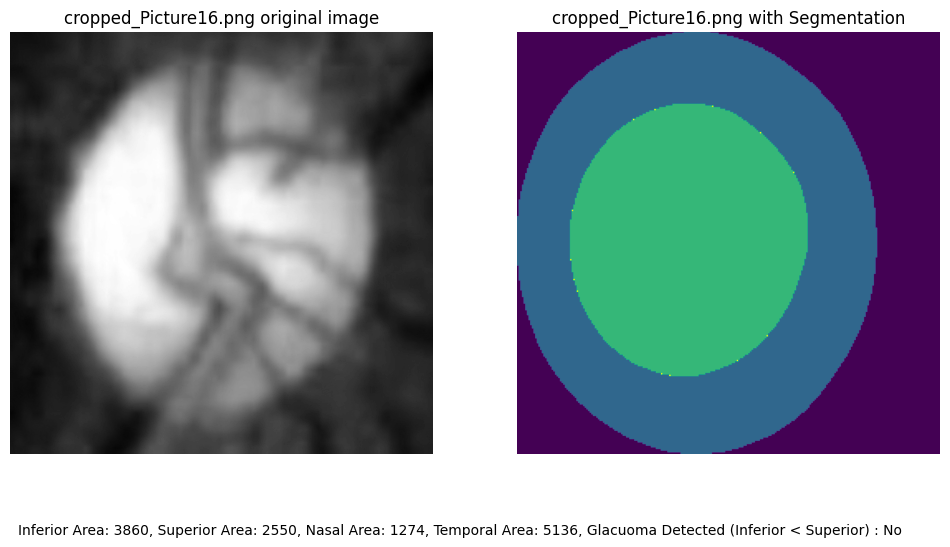

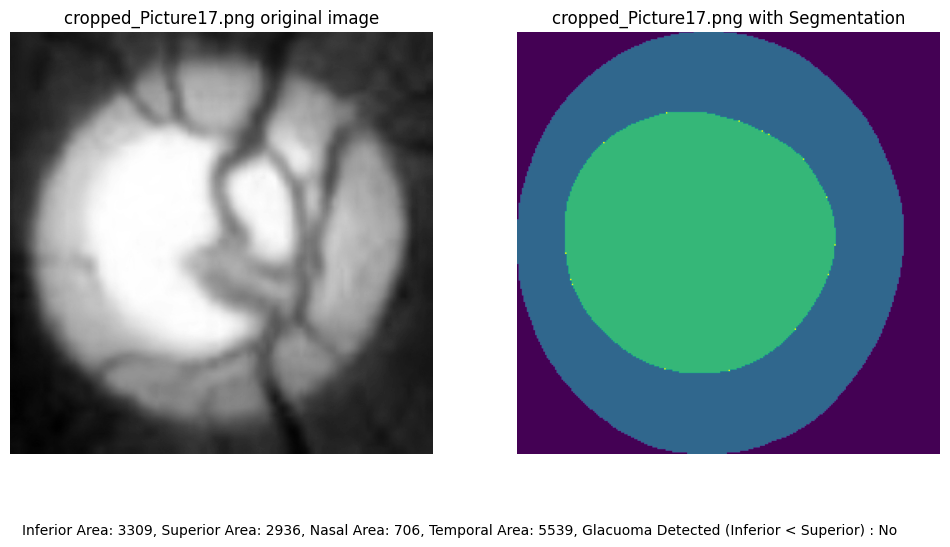

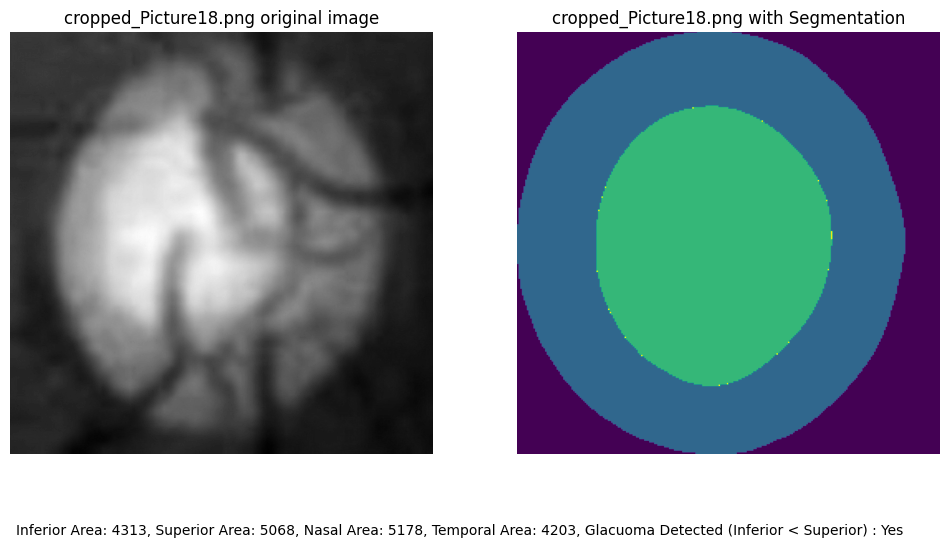

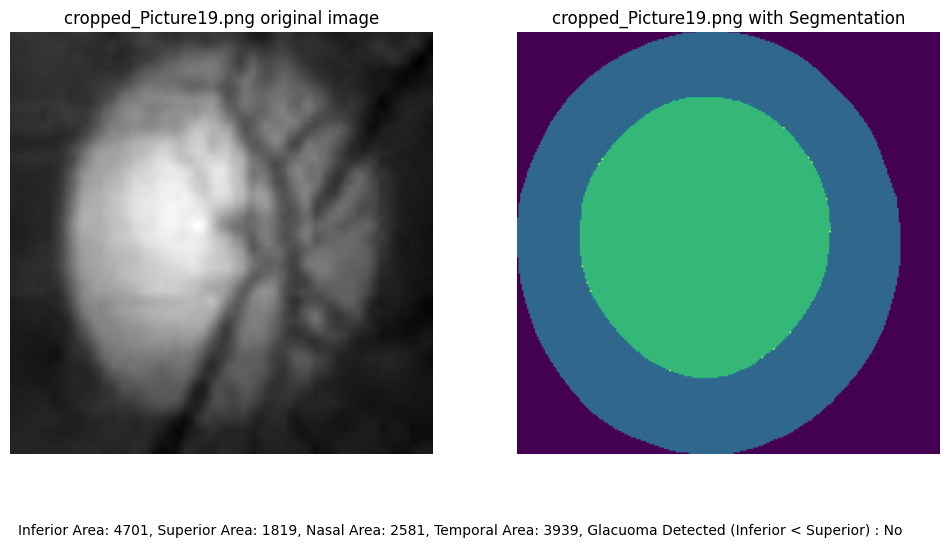

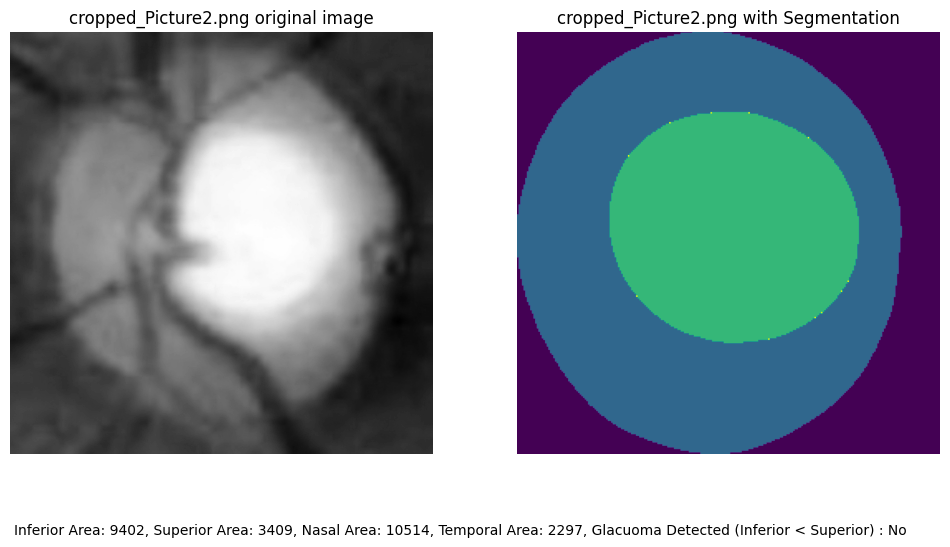

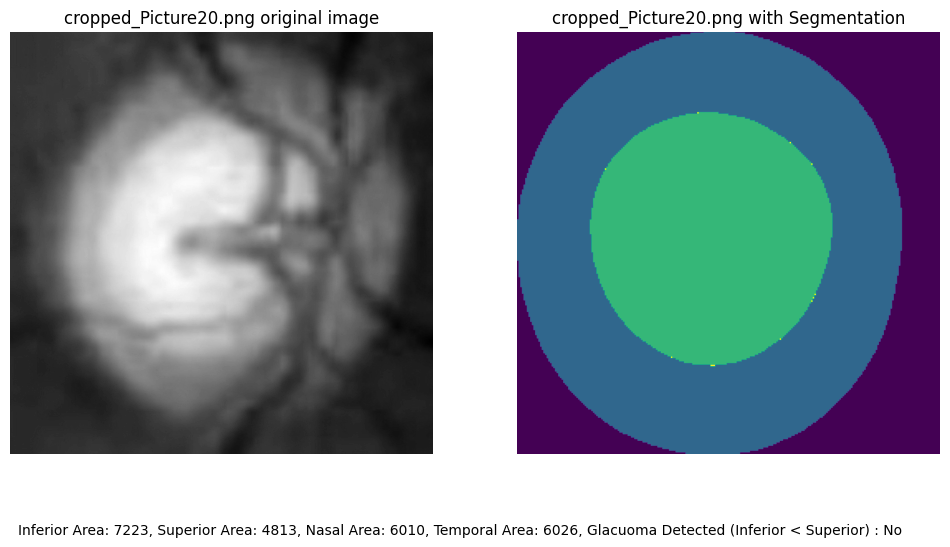

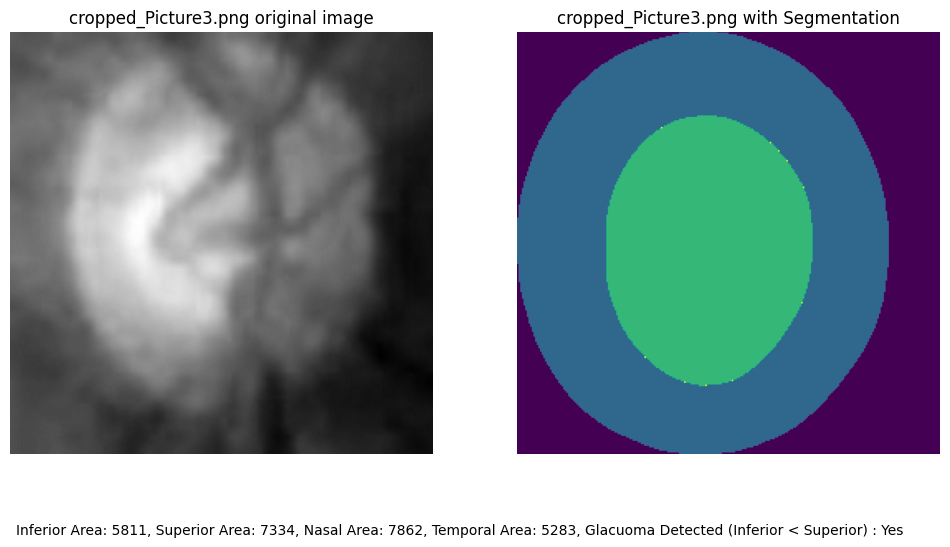

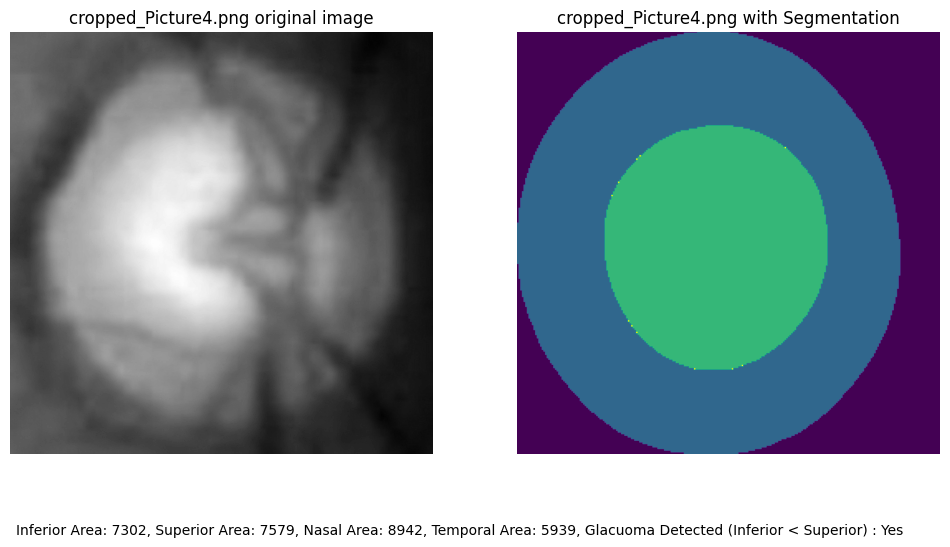

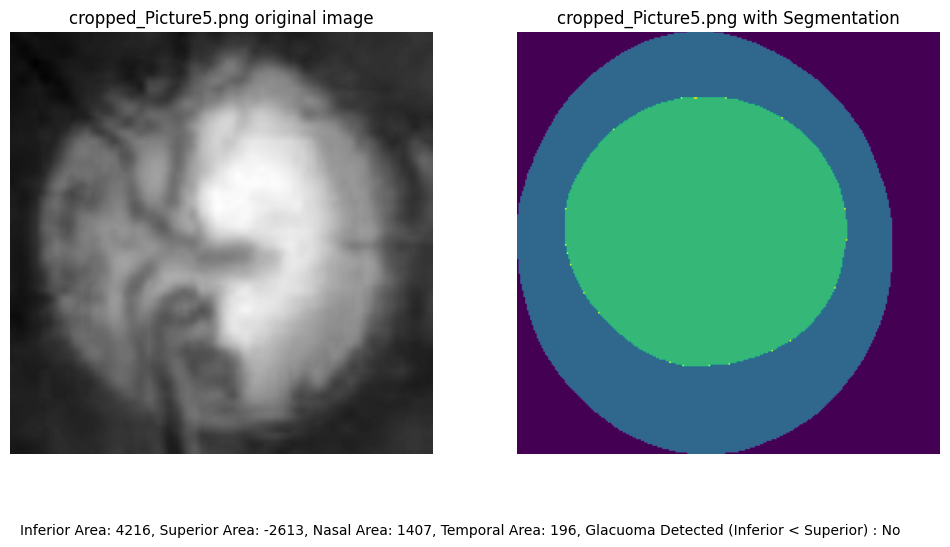

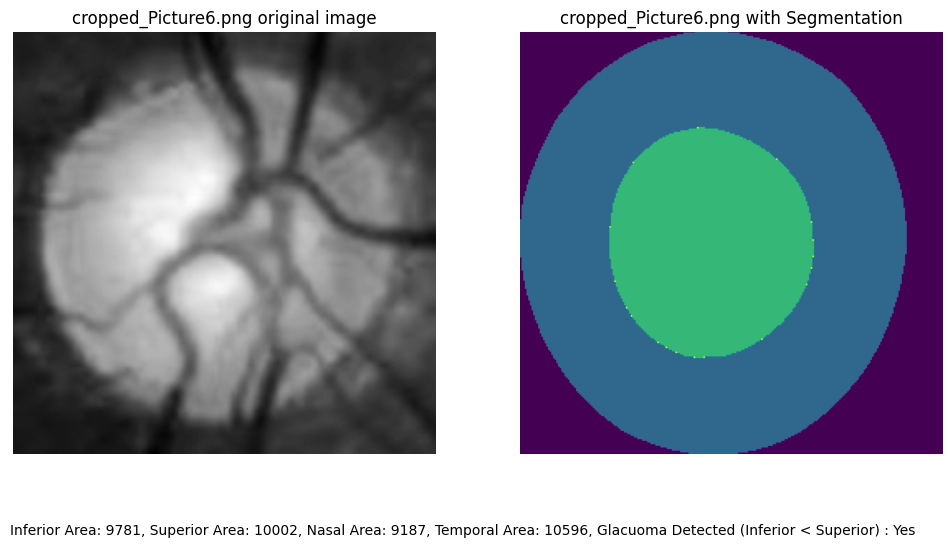

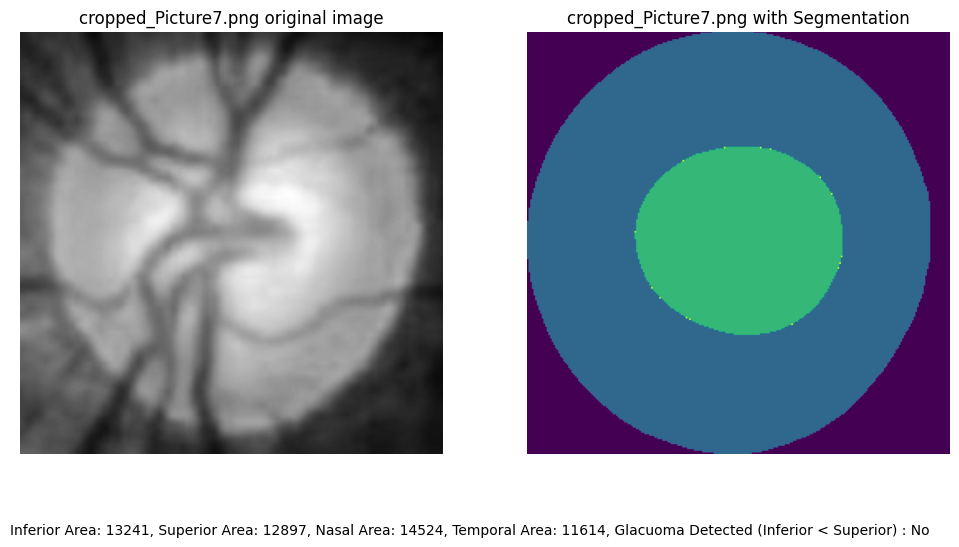

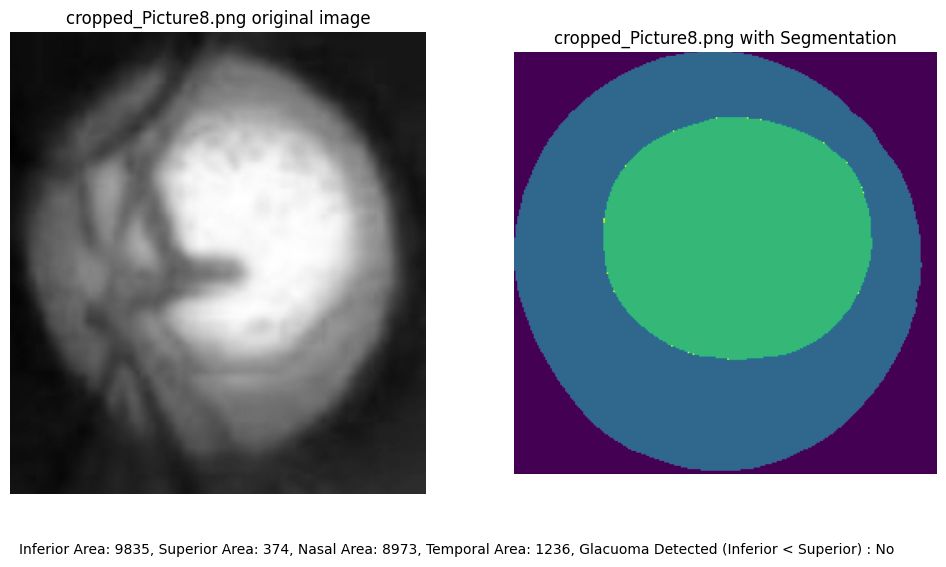

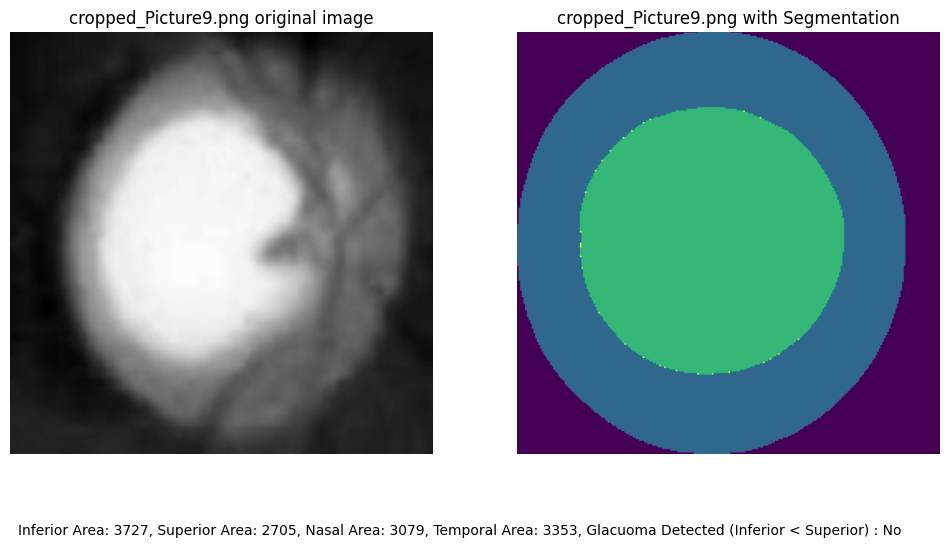

In [22]:
import numpy as np
import torch

# Function to calculate the center of the optic disk
def find_center(mask):
    labeled_array, num_features = label(mask)
    regions = measure.regionprops(labeled_array)
    if len(regions) == 0:
        return None, None
    centroid = regions[0].centroid  # Assuming the largest region is the optic disk
    return int(centroid[0]), int(centroid[1])

# Function to calculate the areas of the regions
def calculate_areas(disk, cup):
    center_y, center_x = find_center(disk)
    if center_y is None or center_x is None:
        return None, None, None, None, None

    # Create boolean masks for each region
    inferior_mask = np.zeros_like(disk)
    inferior_mask[center_y:, :] = 1

    superior_mask = np.zeros_like(disk)
    superior_mask[:center_y, :] = 1

    nasal_mask = np.zeros_like(disk)
    nasal_mask[:, :center_x] = 1

    temporal_mask = np.zeros_like(disk)
    temporal_mask[:, center_x:] = 1

    # Calculate the area of each region (disk - cup) within the specific mask
    inferior_area = np.sum((disk - cup) * inferior_mask)
    superior_area = np.sum((disk - cup) * superior_mask)
    nasal_area = np.sum((disk - cup) * nasal_mask)
    temporal_area = np.sum((disk - cup) * temporal_mask)

    # Check if the inferior area is smaller than the superior area
    inferior_smaller_than_superior = inferior_area < superior_area

    return inferior_area, superior_area, nasal_area, temporal_area, inferior_smaller_than_superior

# Function to visualize the bounding boxes and save the image (modified to include areas and comparison)
def visualize_predictions(image, pred_od, pred_oc, original_size, filename, save_dir):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Original Image
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title(f"{filename} original image")
    ax[0].axis("off")

    # Prediction Image
    pred_od_mask = pred_od.numpy().reshape(256, 256) + (2 * pred_oc.numpy().reshape(256, 256))
    ax[1].imshow(pred_od_mask)
    ax[1].set_title(f"{filename} with Segmentation")
    ax[1].axis("off")

    # Calculate areas and add text to the plot
    inferior_area, superior_area, nasal_area, temporal_area, inferior_smaller_than_superior = calculate_areas(pred_od.numpy().reshape(256, 256), pred_oc.numpy().reshape(256, 256))
    if inferior_area is not None:
        plt.figtext(0.5, 0.01, f"Inferior Area: {inferior_area}, Superior Area: {superior_area}, Nasal Area: {nasal_area}, Temporal Area: {temporal_area}, Glacuoma Detected (Inferior < Superior) : {'Yes' if inferior_smaller_than_superior else 'No'}", ha="center", fontsize=10)

#     # Save the figure with the same filename
#     plt.savefig(os.path.join(save_dir, filename))
#     plt.close(fig)

# Example usage in your loop
for i, (image, original_image) in enumerate(zip(test_images, original_images)):
    logits = get_predictions(image, model)
    pred_od = (logits[:, 0, :, :] >= 0.5).type(torch.int8).cpu()
    pred_oc = (logits[:, 1, :, :] >= 0.5).type(torch.int8).cpu()

    # Visualize predictions and save images
    visualize_predictions(original_image, pred_od, pred_oc, image.size, filenames[i], save_folder)


In [20]:

# Zip the saved images
zip_filename = '/kaggle/working/final_contoured_images.zip'
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for root, _, files in os.walk(save_folder):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), save_folder))

# NRR AREA AND GLACUAMO DETECTION